In [1]:
import os
from pathlib import Path

project_root = "/content/ai-digital-toxicity-audit"

# If the repo isn't there yet in this runtime, clone it again
if not Path(project_root).exists():
    !git clone https://github.com/afreen-iws/ai-digital-toxicity-audit.git $project_root

%cd $project_root
print("Working directory:", os.getcwd())


Cloning into '/content/ai-digital-toxicity-audit'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 5), reused 19 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 314.62 KiB | 34.96 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/ai-digital-toxicity-audit
Working directory: /content/ai-digital-toxicity-audit


In [2]:
!ls -R data


ls: cannot access 'data': No such file or directory


In [3]:
import kagglehub

path = kagglehub.dataset_download("parthplc/facebook-hateful-meme-dataset")
print("Dataset downloaded to:", path)


Using Colab cache for faster access to the 'facebook-hateful-meme-dataset' dataset.
Dataset downloaded to: /kaggle/input/facebook-hateful-meme-dataset


In [4]:
import shutil
from pathlib import Path

source = Path(path)
target = Path("data/raw/hateful_memes")

target.mkdir(parents=True, exist_ok=True)

shutil.copytree(source, target, dirs_exist_ok=True)

print("Copied to:", target)
!ls -R data/raw/hateful_memes


Copied to: data/raw/hateful_memes
data/raw/hateful_memes:
data

data/raw/hateful_memes/data:
dev.jsonl  img	LICENSE.txt  README.md	test.jsonl  train.jsonl

data/raw/hateful_memes/data/img:
01235.png  14728.png  28764.png  42650.png  57183.png  71390.png  85209.png
01236.png  14765.png  28765.png  42653.png  57189.png  71392.png  85213.png
01243.png  14769.png  28790.png  42658.png  57193.png  71396.png  85237.png
01245.png  14782.png  28793.png  42673.png  57198.png  71398.png  85239.png
01247.png  14783.png  28905.png  42675.png  57203.png  71403.png  85243.png
01256.png  14789.png  28930.png  42681.png  57208.png  71428.png  85261.png
01258.png  14793.png  28935.png  42685.png  57209.png  71429.png  85269.png
01264.png  14802.png  28936.png  42687.png  57236.png  71430.png  85271.png
01268.png  14823.png  28945.png  42690.png  57248.png  71432.png  85290.png
01269.png  14829.png  28951.png  42691.png  57249.png  71436.png  85291.png
01274.png  14830.png  28954.png  42693.png  57260.p

In [5]:
!pip install -r requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 149.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 144.0 MB/s eta 0:00:00


In [6]:
import json
import pandas as pd
from pathlib import Path

# Base folder where we copied the dataset earlier
base_dir = Path("data/raw/hateful_memes")

# Find all JSONL files inside it
jsonl_files = list(base_dir.rglob("*.jsonl"))
print("Found JSONL files:")
for p in jsonl_files:
    print(" -", p)

# Pick train/dev by filename (robust to exact path)
train_file = [p for p in jsonl_files if "train" in p.name.lower()][0]
dev_file   = [p for p in jsonl_files if "dev"   in p.name.lower()][0]

print("\nUsing:")
print("Train:", train_file)
print("Dev:  ", dev_file)

def load_jsonl(path: Path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return rows

df_train = pd.DataFrame(load_jsonl(train_file))
df_val   = pd.DataFrame(load_jsonl(dev_file))

df_train.head(), df_val.head()


Found JSONL files:
 - data/raw/hateful_memes/data/test.jsonl
 - data/raw/hateful_memes/data/train.jsonl
 - data/raw/hateful_memes/data/dev.jsonl

Using:
Train: data/raw/hateful_memes/data/train.jsonl
Dev:   data/raw/hateful_memes/data/dev.jsonl


(      id            img  label  \
 0  42953  img/42953.png      0   
 1  23058  img/23058.png      0   
 2  13894  img/13894.png      0   
 3  37408  img/37408.png      0   
 4  82403  img/82403.png      0   
 
                                                 text  
 0   its their character not their color that matters  
 1  don't be afraid to love again everyone is not ...  
 2                           putting bows on your pet  
 3  i love everything and everybody! except for sq...  
 4  everybody loves chocolate chip cookies, even h...  ,
       id            img  label  \
 0   8291  img/08291.png      1   
 1  46971  img/46971.png      1   
 2   3745  img/03745.png      1   
 3  83745  img/83745.png      1   
 4  80243  img/80243.png      1   
 
                                                 text  
 0              white people is this a shooting range  
 1                              bravery at its finest  
 2  your order comes to $37.50 and your white priv...  
 3  it is time.

In [8]:
# The folder where images live is usually the parent of images
dataset_root = train_file.parent  # e.g. data/raw/hateful_memes/data

print("Dataset root:", dataset_root)
print("Sample values in 'img' column:", df_train["img"].head().tolist())


Dataset root: data/raw/hateful_memes/data
Sample values in 'img' column: ['img/42953.png', 'img/23058.png', 'img/13894.png', 'img/37408.png', 'img/82403.png']


In [9]:
from pathlib import Path

def make_image_path(filename: str) -> str:
    """
    Build a full path to the image file from the 'img' value.
    Handles cases where 'img' might be like '12345.png' or 'img/12345.png'.
    """
    filename = str(filename)
    # If it already has .png, use directly
    if filename.lower().endswith(".png"):
        return str(dataset_root / filename)
    else:
        # If not, assume .png extension
        return str(dataset_root / f"{filename}.png")

df_train["image_path"] = df_train["img"].apply(make_image_path)
df_val["image_path"]   = df_val["img"].apply(make_image_path)

df_train[["id", "img", "label", "image_path"]].head()


,id,img,label,image_path
0,42953,img/42953.png,0,data/raw/hateful_memes/data/img/42953.png
1,23058,img/23058.png,0,data/raw/hateful_memes/data/img/23058.png
2,13894,img/13894.png,0,data/raw/hateful_memes/data/img/13894.png
3,37408,img/37408.png,0,data/raw/hateful_memes/data/img/37408.png
4,82403,img/82403.png,0,data/raw/hateful_memes/data/img/82403.png


ID: 97521
Label: Hateful (1)
Image path: data/raw/hateful_memes/data/img/97521.png


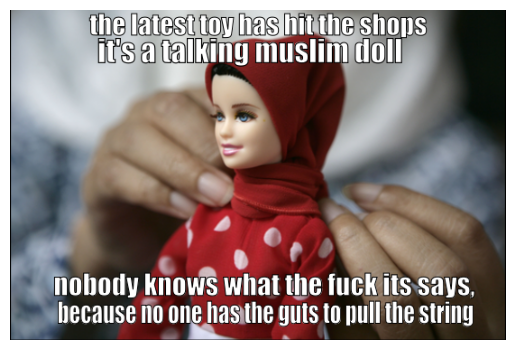

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

row = df_train.sample(1, random_state=42).iloc[0]

print("ID:", row["id"])
print("Label:", "Hateful (1)" if row["label"] == 1 else "Non-hateful (0)")
print("Image path:", row["image_path"])

img = Image.open(row["image_path"]).convert("RGB")
plt.imshow(img)
plt.axis("off");


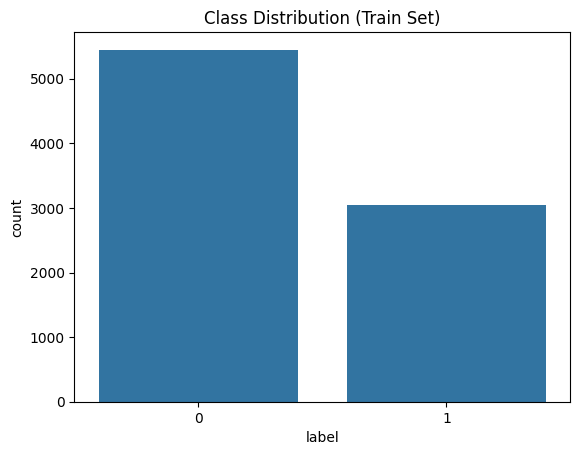

In [11]:
import seaborn as sns

sns.countplot(x=df_train["label"])
plt.title("Class Distribution (Train Set)")
plt.show()


In [12]:
!pip install transformers datasets accelerate evaluate timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.1 MB/s eta 0:00:00


In [13]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification, Trainer, TrainingArguments
import numpy as np
import evaluate


In [14]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [15]:
class ImageDataset(Dataset):
    def __init__(self, df, feature_extractor):
        self.df = df.reset_index(drop=True)
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, "image_path"]
        label = int(self.df.loc[idx, "label"])

        # Load image
        image = Image.open(image_path).convert("RGB")

        # Apply ViT feature extractor
        inputs = self.feature_extractor(images=image, return_tensors="pt")

        # Format output correctly
        item = {k: v.squeeze() for k, v in inputs.items()}
        item["labels"] = torch.tensor(label)

        return item


In [16]:
train_ds = ImageDataset(df_train, feature_extractor)
val_ds   = ImageDataset(df_val, feature_extractor)

len(train_ds), len(val_ds)


(8500, 500)

In [17]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,           # Binary classification
    ignore_mismatched_sizes=True
)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
training_args = TrainingArguments(
    output_dir="./models/checkpoints/vit_image_baseline",
    eval_strategy="epoch",      # If using older transformers, replace with eval_strategy
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,  # keep small for GPU
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none"
)


In [19]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"],
    }


In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-2392472404.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.601300,0.829406,0.506000,0.074906
2,0.555400,0.853524,0.512000,0.306818


TrainOutput(global_step=2126, training_loss=0.600045814227071, metrics={'train_runtime': 449.4255, 'train_samples_per_second': 37.826, 'train_steps_per_second': 4.73, 'total_flos': 1.317363823448064e+18, 'train_loss': 0.600045814227071, 'epoch': 2.0})

In [22]:
eval_results = trainer.evaluate()
eval_results


{'eval_loss': 0.8535239100456238,
 'eval_accuracy': 0.512,
 'eval_f1': 0.3068181818181818,
 'eval_runtime': 9.6512,
 'eval_samples_per_second': 51.807,
 'eval_steps_per_second': 3.316,
 'epoch': 2.0}

In [23]:
save_dir = "./models/checkpoints/vit_image_baseline"
trainer.save_model(save_dir)
feature_extractor.save_pretrained(save_dir)

print("Model saved to:", save_dir)


Model saved to: ./models/checkpoints/vit_image_baseline


In [24]:
!find /content -name "*.ipynb"


/content/ai-digital-toxicity-audit/notebooks/02_baseline_text_model.ipynb
/content/ai-digital-toxicity-audit/notebooks/01_explore_dataset.ipynb


In [25]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!find /content/drive -name "03_image_baseline.ipynb"
